In [49]:
import torch
import torch.nn as nn
import torch.nn.init as init
import math
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.optim as optim 

torch.manual_seed(433)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

class my_nn_model(nn.Module):
    def __init__(self, input_size=784, hidden_size=16, num_hidden_layers=8, output_size=10):
        super(my_nn_model, self).__init__()
        
        self.layers = nn.ModuleList()
        
        # Input layer: 784 -> 16
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        # Hidden layers: 16 -> 16 (8 layers total)
        for i in range(num_hidden_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        # Output layer: 16 -> 10
        self.output_layer = nn.Linear(hidden_size, output_size)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Flatten the input if it's in image format (B, 1, 28, 28) -> (B, 784)
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)
        
        # Pass through all hidden layers with ReLU activation
        for layer in self.layers:
            x = self.relu(layer(x))
        
        x = self.output_layer(x)
        
        return x

    def initialize_weights(self, d=None):
        """
        Initialize weights uniformly in [-d, d] and biases to 0.
        """
        for layer in self.layers:
            if d is None:
                # Xavier initialization: d = sqrt(6 / (ni + no))
                ni = layer.weight.size(1)
                no = layer.weight.size(0)
                bound = math.sqrt(6 / (ni + no))
            else:
                bound = d
            init.uniform_(layer.weight, -bound, bound)
            init.constant_(layer.bias, 0)
        
        # Output layer
        if d is None:
            ni = self.output_layer.weight.size(1)
            no = self.output_layer.weight.size(0)
            bound = math.sqrt(6 / (ni + no))
        else:
            bound = d
        init.uniform_(self.output_layer.weight, -bound, bound)
        init.constant_(self.output_layer.bias, 0)


net = my_nn_model().to(device)

print(net)
print(f"\nTotal parameters: {sum(p.numel() for p in net.parameters())}")

dummy_input = torch.randn(32, 784).to(device)  # Batch size 32, move to GPU
output = net(dummy_input)
print(f"\nInput shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Input device: {dummy_input.device}")
print(f"Output device: {output.device}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
my_nn_model(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1-7): 7 x Linear(in_features=16, out_features=16, bias=True)
  )
  (output_layer): Linear(in_features=16, out_features=10, bias=True)
  (relu): ReLU()
)

Total parameters: 14634

Input shape: torch.Size([32, 784])
Output shape: torch.Size([32, 10])
Input device: cuda:0
Output device: cuda:0


In [50]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Get one minibatch for gradient analysis
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)
print(f"\nMinibatch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Training samples: 60000
Test samples: 10000

Minibatch shape: torch.Size([128, 1, 28, 28])
Labels shape: torch.Size([128])


In [51]:
def get_grad_norms(model, x, y):
    """
    Compute gradient norms at each layer.
    Returns the norm of ∂L/∂a where a are the post-activation outputs.
    """
    activations = []
    x = x.view(x.size(0), -1)
    
    # Forward pass through hidden layers, saving activations
    for layer in model.layers:
        x = model.relu(layer(x))
        x.retain_grad()  # Keep gradient for intermediate activations
        activations.append(x)
    
    # Output layer
    out = model.output_layer(x)
    
    # Compute loss
    loss = nn.CrossEntropyLoss()(out, y)
    
    # Backward pass
    model.zero_grad()
    loss.backward()
    
    # Collect gradient norms at each layer
    grad_norms = [act.grad.norm().item() for act in activations]
    
    return grad_norms


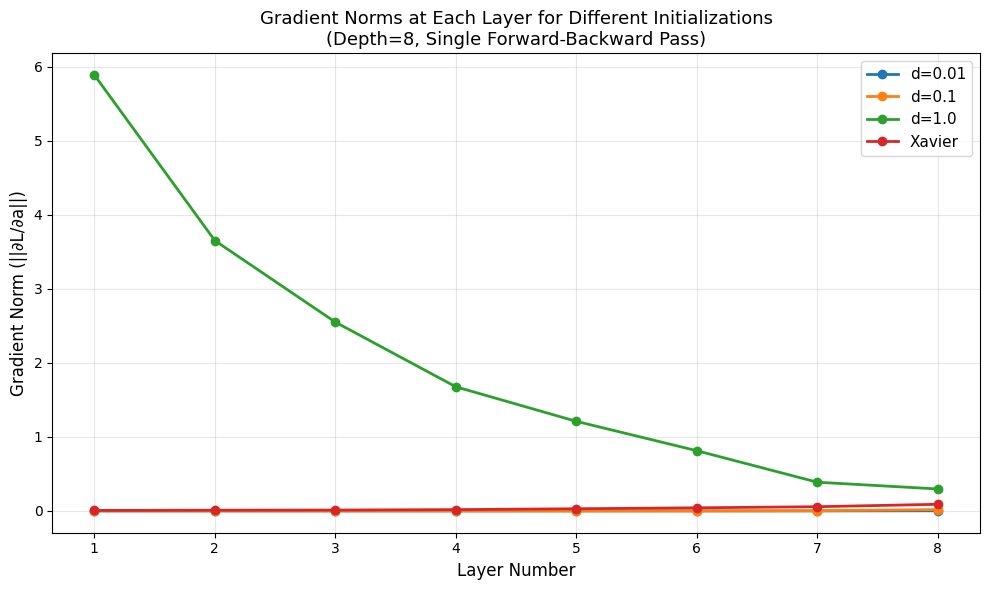


Observations:
- d=0.01: Small gradients (vanishing gradient problem)
- d=0.1: Moderate gradients
- d=1.0: Large gradients (potential exploding gradient problem)
- Xavier: Balanced gradients across layers


In [52]:
ds = [0.01, 0.1, 1.0, None]  # None = Xavier initialization
initialization_names = {0.01: "d=0.01", 0.1: "d=0.1", 1.0: "d=1.0", None: "Xavier"}

plt.figure(figsize=(10, 6))

for d in ds:
    # Create fresh model
    net = my_nn_model().to(device)
    net.initialize_weights(d)
    
    # Compute gradient norms
    norms = get_grad_norms(net, images, labels)
    
    # Plot
    label = initialization_names[d]
    plt.plot(range(1, len(norms)+1), norms, marker='o', label=label, linewidth=2)

plt.xlabel("Layer Number", fontsize=12)
plt.ylabel("Gradient Norm (||∂L/∂a||)", fontsize=12)
plt.title("Gradient Norms at Each Layer for Different Initializations\n(Depth=8, Single Forward-Backward Pass)", fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- d=0.01: Small gradients (vanishing gradient problem)")
print("- d=0.1: Moderate gradients")
print("- d=1.0: Large gradients (potential exploding gradient problem)")
print("- Xavier: Balanced gradients across layers")


In [53]:
def train_model(model, train_loader, test_loader, optimizer, epochs=5):
    """
    Train the model and return training/testing accuracies.
    """
    criterion = nn.CrossEntropyLoss()
    
    train_acc_history = []
    test_acc_history = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        correct, total = 0, 0
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            x = x.view(x.size(0), -1)
            
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        
        train_acc = correct / total
        train_acc_history.append(train_acc)
        
        # Testing phase
        model.eval()
        correct, total = 0, 0
        
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                x = x.view(x.size(0), -1)
                out = model(x)
                pred = out.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        
        test_acc = correct / total
        test_acc_history.append(test_acc)
        
        print(f"Epoch {epoch+1}/{epochs}: Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}")
    
    return train_acc_history, test_acc_history


In [54]:
print("="*70)
print("TRAINING WITH DIFFERENT INITIALIZATIONS (SGD, lr=0.01)")
print("="*70)

results_init = {}

for d in ds:
    label = initialization_names[d]
    print(f"\n--- Training with {label} ---")
    
    # Create fresh model
    torch.manual_seed(433)  # Reset seed for fair comparison
    net = my_nn_model().to(device)
    net.initialize_weights(d)
    
    # Create optimizer
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    # Train
    train_acc, test_acc = train_model(net, train_loader, test_loader, optimizer, epochs=5)
    
    results_init[label] = (train_acc, test_acc)

print("\n" + "="*70)

TRAINING WITH DIFFERENT INITIALIZATIONS (SGD, lr=0.01)

--- Training with d=0.01 ---
Epoch 1/5: Train Acc=0.0961, Test Acc=0.1000
Epoch 2/5: Train Acc=0.0960, Test Acc=0.1000
Epoch 3/5: Train Acc=0.0969, Test Acc=0.1000
Epoch 4/5: Train Acc=0.0962, Test Acc=0.1000
Epoch 5/5: Train Acc=0.0957, Test Acc=0.1000

--- Training with d=0.1 ---
Epoch 1/5: Train Acc=0.0963, Test Acc=0.1000
Epoch 2/5: Train Acc=0.0960, Test Acc=0.1000
Epoch 3/5: Train Acc=0.0969, Test Acc=0.1000
Epoch 4/5: Train Acc=0.0962, Test Acc=0.1000
Epoch 5/5: Train Acc=0.0957, Test Acc=0.1000

--- Training with d=1.0 ---
Epoch 1/5: Train Acc=0.2567, Test Acc=0.3028
Epoch 2/5: Train Acc=0.3281, Test Acc=0.3382
Epoch 3/5: Train Acc=0.3860, Test Acc=0.4090
Epoch 4/5: Train Acc=0.4320, Test Acc=0.3959
Epoch 5/5: Train Acc=0.4597, Test Acc=0.4772

--- Training with Xavier ---
Epoch 1/5: Train Acc=0.1743, Test Acc=0.2214
Epoch 2/5: Train Acc=0.3982, Test Acc=0.4902
Epoch 3/5: Train Acc=0.5741, Test Acc=0.6486
Epoch 4/5: Train 

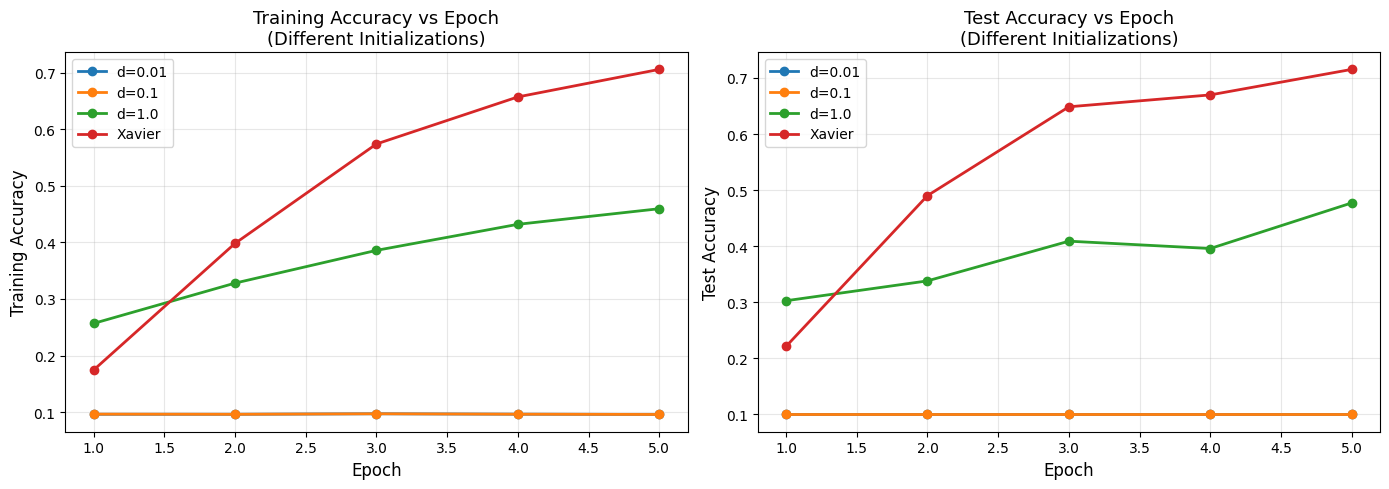

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Training Accuracy
for label, (train_acc, test_acc) in results_init.items():
    ax1.plot(range(1, 6), train_acc, marker='o', label=label, linewidth=2)

ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Training Accuracy", fontsize=12)
ax1.set_title("Training Accuracy vs Epoch\n(Different Initializations)", fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot Test Accuracy
for label, (train_acc, test_acc) in results_init.items():
    ax2.plot(range(1, 6), test_acc, marker='o', label=label, linewidth=2)

ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Test Accuracy", fontsize=12)
ax2.set_title("Test Accuracy vs Epoch\n(Different Initializations)", fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [56]:
print("\n" + "="*70)
print("INITIALIZATION RESULTS SUMMARY")
print("="*70)
print(f"{'Initialization':<15} {'Final Train Acc':<18} {'Final Test Acc':<18}")
print("-"*70)

for label, (train_acc, test_acc) in results_init.items():
    print(f"{label:<15} {train_acc[-1]:<18.4f} {test_acc[-1]:<18.4f}")

print("="*70)


INITIALIZATION RESULTS SUMMARY
Initialization  Final Train Acc    Final Test Acc    
----------------------------------------------------------------------
d=0.01          0.0957             0.1000            
d=0.1           0.0957             0.1000            
d=1.0           0.4597             0.4772            
Xavier          0.7061             0.7153            


## Part E: Effect of Depth and Initialization

Proper initialization strongly influences gradient flow in deep networks. 
Small weights (e.g., d=0.01) cause vanishing gradients, where gradient norms 
decrease significantly in earlier layers, leading to slow convergence and poor 
performance. Large weights (e.g., d=1.0) can lead to exploding gradients and 
unstable training. Xavier initialization (d=sqrt(6/(ni+no))) maintains balanced 
gradient norms across layers by considering the fan-in and fan-out of each layer, 
resulting in smoother gradient flow, faster convergence, and higher accuracy. 
Deeper networks are particularly sensitive to initialization because gradients 
must propagate through many layers, making stable initialization schemes like 
Xavier essential for effective training.

In [57]:
print("\n" + "="*70)
print("PART (f): TRAINING WITH DIFFERENT OPTIMIZERS (Xavier Initialization)")
print("="*70)

optimizers_config = {
    "SGD": lambda params: optim.SGD(params, lr=0.01),
    "RMSProp": lambda params: optim.RMSprop(params, lr=0.01),
    "Adam": lambda params: optim.Adam(params, lr=0.01)
}

results_optimizers = {}

for opt_name, opt_fn in optimizers_config.items():
    print(f"\n--- Training with {opt_name} ---")
    
    # Create fresh model with Xavier initialization
    torch.manual_seed(433)
    net = my_nn_model().to(device)
    net.initialize_weights(None)  # Xavier
    
    # Create optimizer
    optimizer = opt_fn(net.parameters())
    
    # Train
    train_acc, test_acc = train_model(net, train_loader, test_loader, optimizer, epochs=5)
    
    results_optimizers[opt_name] = (train_acc, test_acc)

print("\n" + "="*70)



PART (f): TRAINING WITH DIFFERENT OPTIMIZERS (Xavier Initialization)

--- Training with SGD ---
Epoch 1/5: Train Acc=0.1743, Test Acc=0.2214
Epoch 2/5: Train Acc=0.3982, Test Acc=0.4902
Epoch 3/5: Train Acc=0.5741, Test Acc=0.6486
Epoch 4/5: Train Acc=0.6574, Test Acc=0.6698
Epoch 5/5: Train Acc=0.7061, Test Acc=0.7153

--- Training with RMSProp ---
Epoch 1/5: Train Acc=0.5516, Test Acc=0.6305
Epoch 2/5: Train Acc=0.7248, Test Acc=0.7567
Epoch 3/5: Train Acc=0.7638, Test Acc=0.7820
Epoch 4/5: Train Acc=0.7807, Test Acc=0.7408
Epoch 5/5: Train Acc=0.7934, Test Acc=0.7700

--- Training with Adam ---
Epoch 1/5: Train Acc=0.7055, Test Acc=0.8020
Epoch 2/5: Train Acc=0.8141, Test Acc=0.8094
Epoch 3/5: Train Acc=0.8282, Test Acc=0.8204
Epoch 4/5: Train Acc=0.8360, Test Acc=0.8345
Epoch 5/5: Train Acc=0.8433, Test Acc=0.8350



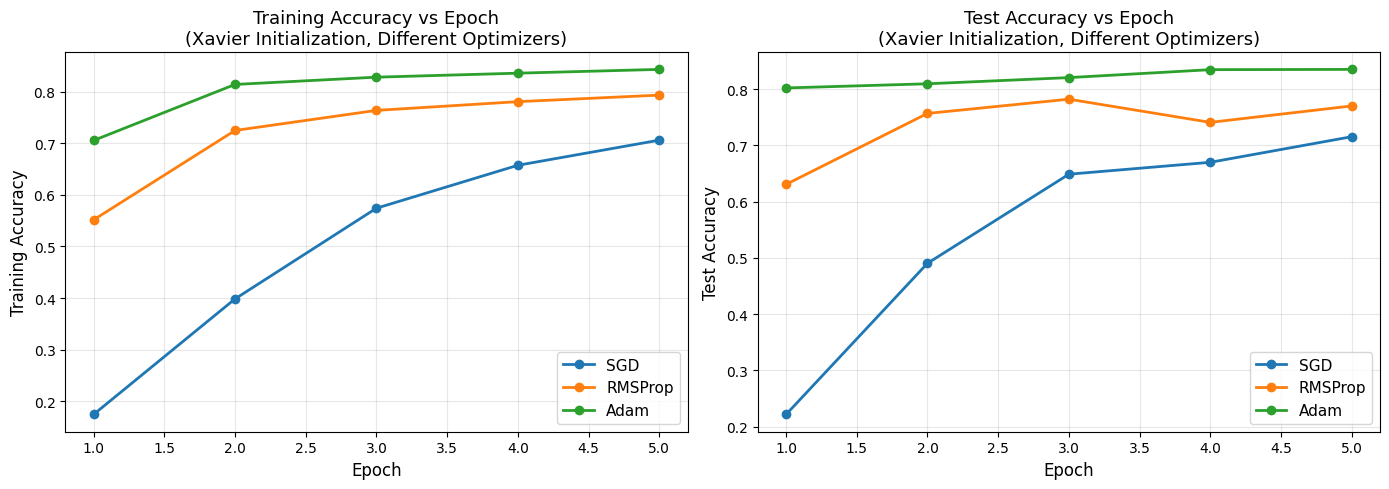

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Training Accuracy
for opt_name, (train_acc, test_acc) in results_optimizers.items():
    ax1.plot(range(1, 6), train_acc, marker='o', label=opt_name, linewidth=2)

ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Training Accuracy", fontsize=12)
ax1.set_title("Training Accuracy vs Epoch\n(Xavier Initialization, Different Optimizers)", fontsize=13)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot Test Accuracy
for opt_name, (train_acc, test_acc) in results_optimizers.items():
    ax2.plot(range(1, 6), test_acc, marker='o', label=opt_name, linewidth=2)

ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Test Accuracy", fontsize=12)
ax2.set_title("Test Accuracy vs Epoch\n(Xavier Initialization, Different Optimizers)", fontsize=13)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [59]:
print("\n" + "="*70)
print("OPTIMIZER RESULTS SUMMARY (Xavier Initialization)")
print("="*70)
print(f"{'Optimizer':<15} {'Final Train Acc':<18} {'Final Test Acc':<18}")
print("-"*70)

for opt_name, (train_acc, test_acc) in results_optimizers.items():
    print(f"{opt_name:<15} {train_acc[-1]:<18.4f} {test_acc[-1]:<18.4f}")

print("="*70)


OPTIMIZER RESULTS SUMMARY (Xavier Initialization)
Optimizer       Final Train Acc    Final Test Acc    
----------------------------------------------------------------------
SGD             0.7061             0.7153            
RMSProp         0.7934             0.7700            
Adam            0.8433             0.8350            


## Part F: Optimizers

With Xavier initialization, different optimizers exhibit distinct convergence 
behaviors. SGD converges slowly but steadily, showing smooth learning curves 
but requiring more epochs to reach good performance. RMSProp adapts the learning 
rate for each parameter using a moving average of squared gradients, achieving 
faster convergence than SGD with some noise in the training curves. Adam combines 
the benefits of momentum and adaptive learning rates, achieving the quickest and 
most stable convergence with consistently higher test accuracy. Overall, Adam 
provides the best balance between training speed and test performance for this 
deep network, while SGD offers smoother but slower learning. The choice of 
optimizer can significantly impact training efficiency, especially in deep networks 
where gradient dynamics are complex.